In [1]:
import sys
root_dir_abspath = '/home/adnen.boumessouer/Anomaly_Detection'

In [2]:
sys.path.insert(0, root_dir_abspath)

In [3]:
import os
from pathlib import Path

import tensorflow as tf
# import skimage
from skimage.util import img_as_ubyte

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import argparse
import time

from processing.preprocessing import Preprocessor
from processing.preprocessing import get_preprocessing_function
from processing import utils
from processing import postprocessing

Using TensorFlow backend.


In [4]:
model_path = "saved_models/mvtec/capsule/baselineCAE/mssim/10-07-2020_08-46-57/baselineCAE_b8_e129.hdf5"

In [5]:
# load model and info
model, info, _ = utils.load_model_HDF5(model_path)
# set parameters
input_directory = info["data"]["input_directory"]
architecture = info["model"]["architecture"]
loss = info["model"]["loss"]
rescale = info["preprocessing"]["rescale"]
shape = info["preprocessing"]["shape"]
color_mode = info["preprocessing"]["color_mode"]
vmin = info["preprocessing"]["vmin"]
vmax = info["preprocessing"]["vmax"]
nb_validation_images = info["data"]["nb_validation_images"]

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [7]:
# get the correct preprocessing function
preprocessing_function = info["preprocessing"]["preprocessing"]

In [8]:
# initialize preprocessor
preprocessor = Preprocessor(
    input_directory=input_directory,
    rescale=rescale,
    shape=shape,
    color_mode=color_mode,
    preprocessing_function=preprocessing_function,
)

In [9]:
# get validation generator
validation_generator = preprocessor.get_val_generator(
    batch_size=nb_validation_images, shuffle=True
)

Found 21 images belonging to 1 classes.


In [10]:
# retrieve validation images from generator
imgs_val_input = validation_generator.next()[0]

# retrieve validation image_names
filenames = validation_generator.filenames

# get reconstructed images (i.e predictions) on validation dataset
imgs_val_pred = model.predict(imgs_val_input)

In [11]:
imgs_val_input.shape

(21, 256, 256, 3)

In [12]:
imgs_val_pred.shape

(21, 256, 256, 3)

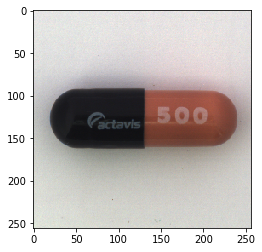

In [14]:
plt.imshow(imgs_val_input[0])

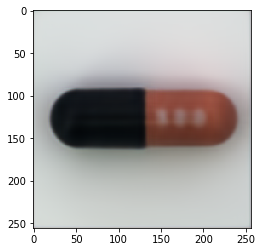

In [13]:
plt.imshow(imgs_val_pred[0])

In [16]:
from skimage.metrics import structural_similarity as ssim

In [17]:
img1 = imgs_val_input[0]
img2 = imgs_val_pred[0]

In [18]:
mssim, grad, resmap = ssim(img1,
                            img2,
                            win_size=11,
                            gaussian_weights=True,
                            sigma=1.5,
                            multichannel=True,
                            gradient=True,
                            full=True,)

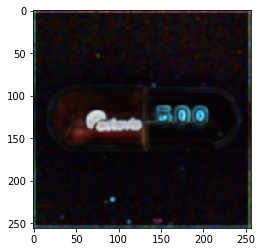

In [25]:
plt.imshow(1-resmap)

In [24]:
resmaps.shape

(256, 256, 3)

In [28]:
np.amin(resmap)

-0.06490098024376018

In [ ]:
def resmaps_ssim(imgs_input, imgs_pred):
    resmaps = np.zeros(shape=imgs_input.shape, dtype="float64")
    for index in range(len(imgs_input)):
        img_input = imgs_input[index]
        img_pred = imgs_pred[index]
        _, resmap = ssim(
            img_input,
            img_pred,
            win_size=11,
            gaussian_weights=True,
            sigma=1.5,
            multichannel=True,
            full=True,
        )
        # resmap = np.expand_dims(resmap, axis=-1)
        resmaps[index] = 1 - resmap
    resmaps = np.clip(resmaps, a_min=-1, a_max=1)
    return resmaps